In [1]:
from sklearn.utils import compute_class_weight
import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import glob
import os
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.preprocessing import StandardScaler
import bottleneck as bn
from sklearn import metrics
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import roc_curve
import numpy as np
import os
import random
#import utils.datasets as ds
#import utils.augmentation as aug
#import utils.helper as hlp
import matplotlib.pyplot as plt
#from utils import helper
import utils

import augmentation as aug
import helper as hlp
import dtw 
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft 

import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import glob
import os
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import bottleneck as bn

from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

import numpy as np
import os

#import utils.datasets as ds
#import utils.augmentation as aug
#import utils.helper as hlp
import matplotlib.pyplot as plt
#from utils import helper
import utils

import augmentation as aug
import helper as hlp
import dtw 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import  FUNCIONES_preprocesado as fnc
from FUNCIONES_preprocesado import target, build_cnn_model,  trans_fourier_2, trans_fourier_3, plot_roc, trans_fourier_1, fourier


#MODELO DE RED

def build_cnn_model(unit, kernel, reg):
    model = Sequential()
    # 1 Convolution layer with Max polling
    model.add(Conv1D(unit, kernel, strides=1, activation='relu', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(l=reg))) #kernel_regularizer=regularizers.l2(l=0.2)
    model.add(keras.layers.MaxPooling1D(2))
    # 2 Flatten layer
    model.add(Flatten())
    # 1 Full connected layer
    model.add(Dense(1, activation = 'sigmoid')) # 2 classes
    #compile model
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'AUC'])
    return model


def build_LSTM_model(unit, reg):
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    model = keras.Sequential()
    

    model.add(keras.layers.LSTM(unit, input_shape=input_shape, activation='relu', dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dropout(reg))
    #model.add(keras.layers.Dense(30, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
    return model


#CURVA ROC
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=1, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def clean_infal(recordname_new):
    record = pd.read_csv(os.path.join('CSV',recordname_new+'.csv'), header=None)
    record = np.asarray(record)
    print(len(record))
    non_0 = np.flatnonzero(record)
    if np.trunc((non_0[-1])/2)<int(len(record)-1):
        record=np.delete(record, range(int(np.trunc((non_0[-1])/2)+1),int(len(record))),0)
    if non_0[0] >0 and non_0[0] >1:
        record=np.delete(record, range(0,int(np.trunc((non_0[0])/2))),0)
    print(len(record))
    return record
    

#FUNCIÓN QUE LIMPIA HUECOS EN BLANCO DENTRO DE LA SERIE
def gap_clean(record, umbral): 
    lista1 = []
    #print(len(record))
    for i in range(0,len(record)):
        if np.array_equal(record[i:i+umbral],np.zeros((umbral,2))):
            lista1.append(i)

    if len(lista1)!=0:
        lista2=[lista1[0]]        
        for j in range(0,len(lista1)-1):
            if int(lista1[j])!=int(lista1[j+1])-1:
                lista2.append(lista1[j])
                lista2.append(lista1[j+1])

        lista2.append(lista1[-1])
        print(lista2)

        for n in range(1,len(lista2)+1,2):
            record=np.delete(record, range(int(lista2[len(lista2)-n-1]),int(lista2[len(lista2)-n])+umbral),0)

    print(len(record))
    return record


#CONVERTIMOS 0'S A NAN
def zeros_to_nan(record, minimo_FHR, minimo_UC, maximo_FHR, maximo_UC):
    record[:,0]=[np.nan if value==0 or value<minimo_FHR or value>maximo_FHR  else value for value in record[:,0]]
    record[:,1]=[np.nan if value==0 or value<minimo_UC or value>maximo_UC else value for value in record[:,1]]
    
    return record

def fourier(matriz):
    N = matriz.shape[1]
    matriz_f_n = np.zeros((len(matriz),N//2, 2))
    for i in range(len(matriz)):
        close_fft_FHR = np.fft.fft(matriz[i,:,0])/N
        fft_df_FHR = pd.DataFrame({'fft': close_fft_FHR})
        fft_list_FHR = np.asarray(fft_df_FHR['fft'].tolist())
        matriz_f_n[i,:,0] = np.abs(np.copy(fft_list_FHR)[0:N//2])
        close_fft_UC = np.fft.fft(matriz[i,:,1])/N
        fft_df_UC = pd.DataFrame({'fft': close_fft_UC})
        fft_list_UC = np.asarray(fft_df_UC['fft'].tolist())
        matriz_f_n[i,:,1] = np.abs(np.copy(fft_list_UC)[0:N//2])
    return matriz_f_n

In [2]:
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
matriz.shape

(549, 8818, 2)

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
Best: 0.658050 using {'kernel': 2, 'reg': 0.5, 'unit': 10}
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test set accuracy score for best params in fold 1: 0.7297297297297297
Test set AUC score for best params in fold 1 : 0.7238095238095239

(512, 599, 2) (37, 599, 2) (512,) (37,)
Best: 0.671764 using {'kernel': 2, 'reg': 0.5, 'unit': 3}
Test set accuracy score for best params in fold 2: 0.5135135135135135
Test set AUC score for best params in fold 2 : 0.5357142857142857

(512, 599, 2) (37, 599, 2) (512,) (37,)
Best: 0.665362 using {'kernel': 5, 'reg': 0.3, 'unit': 5}
Test set 

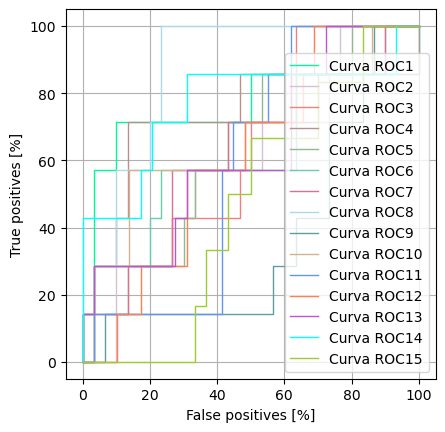

Mean accuracy score: 0.6094594594594595
Mean AUC score: 0.5965626710454296


In [8]:
# Selecciona las últimas 4800 columnas de la matriz y convierte todos los elementos a números de punto flotante de 32 bits
matriz = matriz[:,-4800:,:].astype("float32") 
# Crea una variable 'y' a partir de los datos de etiquetas y el valor umbral 7.15. También crea las variables 'neg' y 'pos', que no se utilizan posteriormente.
y, neg, pos =  fnc.target(etiqueta, 7.15)
# Convierte todos los elementos de 'y' a números de punto flotante de 32 bits y reorganiza la matriz en una sola dimensión
y = y.astype("float32").reshape(-1)
# Calculamos la transformada de Fourier de las señales
matriz_f = fnc.fourier(matriz)

# Fijamos la semilla para asegurar la reproducibilidad de los resultados
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Definimos una estrategia de validación cruzada estratificada
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
# Inicializamos los contadores
fold_num = 1
num = 0
scores = []
AUC_scores = []

# Iteramos sobre cada conjunto de entrenamiento y prueba generado por la estrategia de validación cruzada
for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    # Configurar los pesos de clase para abordar el desequilibrio de clase en el conjunto de entrenamiento
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    input_shape = (x_tr.shape[1], x_tr.shape[2])

    # Define el modelo de la CNN
    model = KerasClassifier(build_fn=build_cnn_model, 
                            batch_size=32, epochs=100, verbose = 0)
    
    # Define los parámetros para la búsqueda en cuadrícula de los hiperparámetros del modelo
    params={'reg': [0.1, 0.3, 0.5],
            'unit': [3, 5, 10], 
            'kernel': [2, 3, 5]}

    # Realiza la búsqueda en cuadrícula de los hiperparámetros del modelo
    gs = GridSearchCV(estimator=model, param_grid=params, cv=KFold(5), scoring = 'roc_auc') #, random_state=2
    gs = gs.fit(x_tr, y_tr, class_weight=class_weights)

    import os

    if not os.path.isdir('Definitivo//CNN//Fourier//7.15//Semilla_'+str(seed)):
        os.mkdir('Definitivo//CNN//Fourier//7.15//Semilla_'+str(seed))

    # Guarda el modelo con los mejores parámetros
    gs.best_estimator_.model.save('Definitivo/CNN/Fourier/7.15/Semilla_'+str(seed)+'/filename_'+str(fold_num)+'.h5')
    print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
    
    # Predecir las probabilidades y las etiquetas para el conjunto de prueba utilizando el modelo GridSearchCV optimizado
    y_pre = gs.predict_proba(x_te)
    y_pred = gs.predict(x_te)
    
    # Calcular la puntuación de exactitud y la puntuación AUC-ROC para el conjunto de prueba
    score, score_1 = metrics.accuracy_score(y_te, y_pred), metrics.roc_auc_score(y_te, y_pred) 
    
    # Almacenar las puntuaciones de exactitud y AUC-ROC en una lista para cada iteración de la validación cruzada
    scores.append(score)
    AUC_scores.append(score_1)
    
    # Imprimir la puntuación de exactitud y la puntuación AUC-ROC para el conjunto de prueba en cada iteración de la validación cruzada
    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')

    # Lista de colores para usar en las curvas ROC de cada iteración de la validación cruzada
    lista_colors = ['lightsteelblue', 'mediumspringgreen', 'thistle', 'lightcoral', 'rosybrown', 
                    'darkseagreen', 'mediumaquamarine', 'palevioletred', 'lightblue',
                'cadetblue', 'tan', 'cornflowerblue', 'coral', 'mediumorchid', 'cyan', 
                    'yellowgreen', 'lightpink', 'goldenrod','peru', 'orange']

    # Graficar la curva ROC para la iteración actual de la validación cruzada utilizando el método 'plot_roc' y los colores de la lista 'lista_colors'
    plot_roc(f"Curva ROC{fold_num}", y_te, y_pre[:,1], color=lista_colors[fold_num])
    plt.legend(loc='lower right');

    fold_num += 1
    
# Mostrar todas las curvas ROC graficadas en el mismo plano   
plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 